# Set up environment

In [102]:
import gymnasium as gym
import numpy as np
import pandas as pd
import torch

# 数据准备

In [103]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [104]:
tech_daily = pd.read_csv(r"data\科技股票.csv")
tech_daily.set_index('date', inplace=True)
tech_daily.columns=['AAPL','GOOG','MSFT']
tech_daily

,AAPL,GOOG,MSFT
date,,,
2022-01-03,178.270326,144.088458,324.504611
2022-01-04,176.007789,143.434930,318.940290
2022-01-05,171.326001,136.717897,306.696845
2022-01-06,168.465997,136.616093,304.273361
2022-01-07,168.632504,136.073308,304.428464
...,...,...,...
2025-11-03,268.789439,284.120000,517.030000
2025-11-04,269.778480,278.060000,514.330000
2025-11-05,269.878383,284.750000,507.160000


In [105]:
debt=pd.read_csv(r"data\无风险.csv",encoding='gbk')
debt.set_index('date', inplace=True)
debt.columns=['US_debt']
debt

,US_debt
date,
2022-01-03,1.63
2022-01-04,1.66
2022-01-05,1.71
2022-01-06,1.73
2022-01-07,1.76
...,...
2025-11-03,4.13
2025-11-04,4.10
2025-11-05,4.17


In [106]:
tmp=pd.read_csv(r"data\指数和贵金属.csv", encoding='gbk')
tmp.columns=['date','SP500','Gold']
tmp.set_index('date', inplace=True)
tmp

,SP500,Gold
date,,
2022-01-03,4796.56,1801.3
2022-01-04,4793.54,1814.9
2022-01-05,4700.58,1810.6
2022-01-06,4696.05,1790.9
2022-01-07,4677.03,1796.5
...,...,...
2025-11-03,6851.97,4013.7
2025-11-04,6771.55,3941.3
2025-11-05,6796.29,3990.4


In [107]:
df=pd.merge(tech_daily,debt,how='left',on='date')
df=pd.merge(df,tmp,how='left',on='date')
df['date']=pd.to_datetime(df.index)
df.set_index('date', inplace=True)
df[df.isnull().values == True]

,AAPL,GOOG,MSFT,US_debt,SP500,Gold
date,,,,,,
2022-10-10,138.103983,98.039090,223.685532,NaN,3612.39,1675.7
2022-11-11,147.475157,96.072547,241.112025,NaN,3992.93,1774.2
2023-10-09,177.082149,138.551849,324.923430,NaN,4335.66,1875.0
2024-10-14,230.005541,165.625113,416.016745,NaN,5859.85,2665.8
2024-11-11,223.220427,181.177047,414.895165,NaN,6001.35,2626.1
2025-10-13,247.420154,244.640000,514.050000,NaN,6654.72,4130.0


In [108]:
df.interpolate(method='time', inplace=True)
df

,AAPL,GOOG,MSFT,US_debt,SP500,Gold
date,,,,,,
2022-01-03,178.270326,144.088458,324.504611,1.63,4796.56,1801.3
2022-01-04,176.007789,143.434930,318.940290,1.66,4793.54,1814.9
2022-01-05,171.326001,136.717897,306.696845,1.71,4700.58,1810.6
2022-01-06,168.465997,136.616093,304.273361,1.73,4696.05,1790.9
2022-01-07,168.632504,136.073308,304.428464,1.76,4677.03,1796.5
...,...,...,...,...,...,...
2025-11-03,268.789439,284.120000,517.030000,4.13,6851.97,4013.7
2025-11-04,269.778480,278.060000,514.330000,4.10,6771.55,3941.3
2025-11-05,269.878383,284.750000,507.160000,4.17,6796.29,3990.4


In [109]:
df = df.sort_index()

print("数据日期范围:", df.index.min(), "→", df.index.max())

def generate_walk_forward_windows(index, train_years=2, test_months=6, step_months=6):
    windows = []

    start_date = index.min().normalize()
    last_date = index.max().normalize()

    current_train_start = start_date

    while True:
        train_start = current_train_start
        train_end = (
            train_start + pd.DateOffset(years=train_years) - pd.DateOffset(days=1)
        )
        test_start = train_end + pd.DateOffset(days=1)
        test_end = (
            test_start + pd.DateOffset(months=test_months) - pd.DateOffset(days=1)
        )

        if test_end > last_date:
            break

        windows.append(
            {
                "train_start": train_start,
                "train_end": train_end,
                "test_start": test_start,
                "test_end": test_end,
            }
        )

        current_train_start = current_train_start + pd.DateOffset(months=step_months)

    return windows


# 生成窗口
windows = generate_walk_forward_windows(
    df.index, train_years=2, test_months=6, step_months=6
)

print(f"共生成 {len(windows)} 个滑动窗口：")
for i, w in enumerate(windows):
    print(
        f"Window {i}: "
        f"Train {w['train_start'].date()} ~ {w['train_end'].date()} | "
        f"Test {w['test_start'].date()} ~ {w['test_end'].date()}"
    )

数据日期范围: 2022-01-03 00:00:00 → 2025-11-07 00:00:00
共生成 3 个滑动窗口：
Window 0: Train 2022-01-03 ~ 2024-01-02 | Test 2024-01-03 ~ 2024-07-02
Window 1: Train 2022-07-03 ~ 2024-07-02 | Test 2024-07-03 ~ 2025-01-02
Window 2: Train 2023-01-03 ~ 2025-01-02 | Test 2025-01-03 ~ 2025-07-02


In [110]:
from math import inf

from networkx import sigma
from pyparsing import deque


class PortfolioOptimizationEnv(gym.Env):
    def __init__(
        self, tickers, window_size, start_date, end_date, initial_balance, seed=None
    ):
        super().__init__()
        self.tickers = tickers
        self.window_size = window_size
        self.initial_balance = initial_balance

        # 分别存储原始价格和指标
        self.raw_data, self.feature_data = self.get_data(tickers, start_date, end_date)
        self.n_features = self.feature_data.shape[1]

        self.action_space = gym.spaces.Box(low=0, high=1, shape=(len(tickers),))
        self.observation_space = gym.spaces.Box(
            low=-inf, high=inf, shape=(window_size, self.n_features)
        )

        self.return_window = deque(maxlen=window_size)
        self.last_action = np.ones(len(tickers)) / len(tickers)

        if seed is not None:
            np.random.seed(seed)
            self.action_space.seed(seed)
            torch.manual_seed(seed)
            if torch.cuda.is_available():
                torch.cuda.manual_seed_all(seed)

    def get_data(self, tickers, start_date, end_date):
        data = df.copy().dropna()
        data = data.loc[start_date:end_date, tickers]

        # 保存原始价格（用于计算投资组合收益）
        raw_data = data.copy()

        # 计算特征指标
        returns = data.pct_change()

        mom_frames = []
        for window in [5, 20]:
            mom = data / data.shift(window) - 1
            mom.columns = [f"{col}_mom_{window}" for col in data.columns]
            mom_frames.append(mom)

        vol = returns.rolling(window=20, min_periods=1).std()
        vol.columns = [f"{col}_vol_20" for col in data.columns]

        ma = data.rolling(window=20, min_periods=1).mean()
        ma_dev = data / ma - 1
        ma_dev.columns = [f"{col}_ma_dev_20" for col in data.columns]

        returns.columns = [f"{col}_ret" for col in data.columns]

        # 特征数据：returns, vol, ma_dev, momentum（不包含原始价格）
        feature_data = pd.concat([returns, vol, ma_dev] + mom_frames, axis=1)
        raw_data = raw_data.dropna()
        feature_data = feature_data.reindex(raw_data.index)
        feature_data.fillna(method="ffill", inplace=True)
        feature_data.fillna(method="bfill", inplace=True)

        return raw_data.dropna(), feature_data.dropna()

    def reset(self, seed=None):
        self.balance = self.initial_balance
        self.current_step = self.window_size

        self.return_window.clear()
        self.last_action = np.ones(len(self.tickers)) / len(self.tickers)

        # 使用特征数据作为观察
        obs = self.feature_data.iloc[
            self.current_step - self.window_size : self.current_step
        ].values
        info = {"balance": self.balance}
        return obs, info

    def step(self, action):
        # SAC已经输出归一化的动作，因此不需要进行softmax
        action = np.asarray(action).ravel()
        action = np.clip(action, 0, 1)
        action = action / np.sum(action + 1e-8)

        prev_balance = self.balance

        # 从原始价格计算实际收益
        current_price = self.raw_data.iloc[self.current_step].values[
            : len(self.tickers)
        ]
        prev_price = self.raw_data.iloc[self.current_step - 1].values[
            : len(self.tickers)
        ]
        asset_returns = current_price / prev_price - 1

        self.return_window.append(asset_returns)

        # 基础奖励：投资组合收益
        portfolio_return = np.sum(asset_returns * action)
        self.balance = self.balance * (1 + portfolio_return)
        base_reward = np.log(self.balance / prev_balance)

        risk_penalty = 0
        if len(self.return_window) >= 5:
            R = np.vstack(self.return_window)
            cov_matrix = np.cov(R.T)
            sigma_p2 = action.T @ cov_matrix @ action
            risk_penalty = sigma_p2

        turnover = np.sum(np.abs(action - self.last_action))
        cost = turnover
        self.last_action = action

        # 总奖励
        lambda_risk = 1
        lambda_turnover = 0.05
        reward = base_reward - lambda_risk * risk_penalty - lambda_turnover * cost

        self.current_step += 1
        done = self.current_step >= len(self.raw_data) - 1

        obs_end = min(len(self.feature_data), self.current_step + self.window_size)
        obs_start = max(0, obs_end - self.window_size)
        obs = self.feature_data.iloc[obs_start:obs_end].values

        terminated = bool(done)
        truncated = False
        info = {"balance": self.balance}

        return obs, reward, terminated, truncated, info

In [ ]:
tickers = df.columns.tolist()
window_size = 30
start_date = '2022-01-03'
end_date = '2025-11-07'
initial_balance = 10000
seed = 8

env = PortfolioOptimizationEnv(
    tickers,
    window_size,
    start_date,
    end_date,
    initial_balance,
    seed)

# Get the initial state
state = env.reset(seed=seed)
# Sample and execute a random action
action = env.action_space.sample()
next_state, reward, terminated, truncated, info = env.step(action)
done = bool(terminated or truncated)
print(f"Action: {action}")
print(f"Reward: {reward}")
print(f"Balance: {info['balance']}")
print(f"Done: {done}")


Action: [0.32697228 0.98727685 0.31871083 0.78854895 0.86989653 0.39108482]
Reward: -0.005810178347567037
Balance: 10161.65097308565
Done: False


C:\Users\HP\AppData\Local\Temp\ipykernel_9704\1164530381.py:64: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  feature_data.fillna(method="ffill", inplace=True)
C:\Users\HP\AppData\Local\Temp\ipykernel_9704\1164530381.py:65: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  feature_data.fillna(method="bfill", inplace=True)


# Training DRL agent

## SAC

In [ ]:
from stable_baselines3 import SAC
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize
from stable_baselines3.common.monitor import Monitor
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# 日志目录
log_dir = "./sb3_logs_wf"
os.makedirs(log_dir, exist_ok=True)


# 为某个时间段构建一个 env 的工厂函数
def make_env_for_period(start_date_str, end_date_str, monitor_file=None):
    def _init():
        env_ = PortfolioOptimizationEnv(
            tickers=tickers,
            window_size=window_size,
            start_date=start_date_str,
            end_date=end_date_str,
            initial_balance=initial_balance,
            seed=seed,
        )
        if monitor_file is not None:
            env_ = Monitor(env_, filename=monitor_file)
        return env_

    return _init


# 保存每个窗口的测试结果
wf_results = []

TOTAL_TIMESTEPS = 20_000

for i, w in enumerate(windows):
    print("=" * 80)
    print(f"Window {i}")
    print(f"Train: {w['train_start'].date()} ~ {w['train_end'].date()}")
    print(f"Test : {w['test_start'].date()} ~ {w['test_end'].date()}")

    train_start_str = w["train_start"].strftime("%Y-%m-%d")
    train_end_str = w["train_end"].strftime("%Y-%m-%d")
    test_start_str = w["test_start"].strftime("%Y-%m-%d")
    test_end_str = w["test_end"].strftime("%Y-%m-%d")

    # -------- 1) 构建训练环境 + 归一化 --------
    monitor_path = os.path.join(log_dir, f"monitor_train_window_{i}.csv")

    vec_train_env = DummyVecEnv(
        [make_env_for_period(train_start_str, train_end_str, monitor_file=monitor_path)]
    )
    vec_train_env = VecNormalize(
        vec_train_env, norm_obs=True, norm_reward=False, clip_obs=10.0
    )

    # -------- 2) 训练 SAC --------
    model = SAC(
        "MlpPolicy",
        vec_train_env,
        verbose=1,
        device=device,
        # 下面这些超参数可以之后再细调
        learning_rate=3e-4,
        batch_size=256,
        buffer_size=200_000,
        tau=0.005,
        ent_coef="auto",
        train_freq=(1, "step"),
        gradient_steps=1,
    )

    model.learn(total_timesteps=TOTAL_TIMESTEPS)

    model_path = os.path.join(log_dir, f"sac_window_{i}.zip")
    vecnorm_path = os.path.join(log_dir, f"sac_vecnorm_window_{i}.pkl")
    model.save(model_path)
    vec_train_env.save(vecnorm_path)
    print(f"Saved model to {model_path}")
    print(f"Saved VecNormalize to {vecnorm_path}")

    # -------- 3) 构建测试环境（使用同一归一化统计） --------
    test_env_raw = DummyVecEnv(
        [make_env_for_period(test_start_str, test_end_str, monitor_file=None)]
    )
    test_env = VecNormalize.load(vecnorm_path, test_env_raw)
    test_env.training = False
    test_env.norm_reward = False

    # -------- 4) 在测试集上回测该窗口策略 --------
    obs = test_env.reset()
    dones = [False]
    balances = []
    rewards = []
    weights_seq = []

    while not dones[0]:
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, dones, infos = test_env.step(action)
        rewards.append(float(reward[0]))
        balances.append(float(infos[0].get("balance", np.nan)))
        weights_seq.append(infos[0].get("weights", None))

    base_env = test_env.envs[0].env
    while hasattr(base_env, "env"):
        base_env = base_env.env
    price_index = base_env.raw_data.index
    start_idx = window_size
    end_idx = start_idx + len(balances)
    dates = price_index[start_idx:end_idx]

    balances_arr = np.asarray(balances, dtype=float)
    rets = (
        balances_arr[1:] / balances_arr[:-1] - 1.0
        if len(balances_arr) > 1
        else np.array([])
    )

    # 简单算一下每个窗口的指标（年化收益、波动、Sharpe）
    def infer_ppy(idx):
        if isinstance(idx, pd.DatetimeIndex) and len(idx) >= 2:
            deltas = np.diff(idx.view("int64")) / 1e9 / 86400.0
            median_days = np.median(deltas) if len(deltas) else 1.0
            if median_days <= 0:
                return 252.0
            return 365.25 / median_days
        return 252.0

    PPY = infer_ppy(dates)

    if len(rets) > 1:
        total_growth = balances_arr[-1] / balances_arr[0]
        ann_return_geom = total_growth ** (PPY / len(rets)) - 1.0
        ann_vol = np.std(rets) * np.sqrt(PPY)
        sharpe = ann_return_geom / ann_vol if ann_vol > 1e-12 else np.nan
    else:
        total_growth = np.nan
        ann_return_geom = np.nan
        ann_vol = np.nan
        sharpe = np.nan

    wf_results.append(
        {
            "window_id": i,
            "train_start": w["train_start"],
            "train_end": w["train_end"],
            "test_start": w["test_start"],
            "test_end": w["test_end"],
            "test_steps": len(rets),
            "start_wealth": balances_arr[0] if len(balances_arr) > 0 else np.nan,
            "end_wealth": balances_arr[-1] if len(balances_arr) > 0 else np.nan,
            "total_growth": total_growth,
            "ann_return": ann_return_geom,
            "ann_vol": ann_vol,
            "sharpe": sharpe,
        }
    )

    print(f"Window {i} 测试结束：")
    print(f"  终值资产: {balances_arr[-1]:.2f}  (初始 {balances_arr[0]:.2f})")
    print(f"  总增长倍数: {total_growth:.4f}")
    print(f"  年化收益:  {ann_return_geom:.2%}")
    print(f"  年化波动:  {ann_vol:.2%}")
    print(f"  Sharpe:    {sharpe:.3f}")


wf_results_df = pd.DataFrame(wf_results)
wf_results_df

Window 0
Train: 2022-01-03 ~ 2024-01-02
Test : 2024-01-03 ~ 2024-07-02
Using cuda device


C:\Users\HP\AppData\Local\Temp\ipykernel_9704\1164530381.py:64: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  feature_data.fillna(method="ffill", inplace=True)
C:\Users\HP\AppData\Local\Temp\ipykernel_9704\1164530381.py:65: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  feature_data.fillna(method="bfill", inplace=True)


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 471      |
|    ep_rew_mean     | -15.2    |
| time/              |          |
|    episodes        | 4        |
|    fps             | 42       |
|    time_elapsed    | 44       |
|    total_timesteps | 1884     |
| train/             |          |
|    actor_loss      | -26.4    |
|    critic_loss     | 1.42     |
|    ent_coef        | 0.586    |
|    ent_coef_loss   | -5.38    |
|    learning_rate   | 0.0003   |
|    n_updates       | 1783     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 471      |
|    ep_rew_mean     | -15.1    |
| time/              |          |
|    episodes        | 8        |
|    fps             | 43       |
|    time_elapsed    | 87       |
|    total_timesteps | 3768     |
| train/             |          |
|    actor_loss      | -37.8    |
|    critic_loss     | 0.362    |
|    ent_coef 

C:\Users\HP\AppData\Local\Temp\ipykernel_9704\1164530381.py:64: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  feature_data.fillna(method="ffill", inplace=True)
C:\Users\HP\AppData\Local\Temp\ipykernel_9704\1164530381.py:65: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  feature_data.fillna(method="bfill", inplace=True)
C:\Users\HP\AppData\Local\Temp\ipykernel_9704\1164530381.py:64: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  feature_data.fillna(method="ffill", inplace=True)
C:\Users\HP\AppData\Local\Temp\ipykernel_9704\1164530381.py:65: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  feature_data.fillna(method="bfill", inplac

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 471      |
|    ep_rew_mean     | -15      |
| time/              |          |
|    episodes        | 4        |
|    fps             | 45       |
|    time_elapsed    | 41       |
|    total_timesteps | 1884     |
| train/             |          |
|    actor_loss      | -25.9    |
|    critic_loss     | 1.34     |
|    ent_coef        | 0.586    |
|    ent_coef_loss   | -5.38    |
|    learning_rate   | 0.0003   |
|    n_updates       | 1783     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 471      |
|    ep_rew_mean     | -15      |
| time/              |          |
|    episodes        | 8        |
|    fps             | 45       |
|    time_elapsed    | 83       |
|    total_timesteps | 3768     |
| train/             |          |
|    actor_loss      | -37.1    |
|    critic_loss     | 0.336    |
|    ent_coef 

C:\Users\HP\AppData\Local\Temp\ipykernel_9704\1164530381.py:64: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  feature_data.fillna(method="ffill", inplace=True)
C:\Users\HP\AppData\Local\Temp\ipykernel_9704\1164530381.py:65: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  feature_data.fillna(method="bfill", inplace=True)
C:\Users\HP\AppData\Local\Temp\ipykernel_9704\1164530381.py:64: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  feature_data.fillna(method="ffill", inplace=True)
C:\Users\HP\AppData\Local\Temp\ipykernel_9704\1164530381.py:65: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  feature_data.fillna(method="bfill", inplac

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 472      |
|    ep_rew_mean     | -15.1    |
| time/              |          |
|    episodes        | 4        |
|    fps             | 45       |
|    time_elapsed    | 41       |
|    total_timesteps | 1888     |
| train/             |          |
|    actor_loss      | -26.5    |
|    critic_loss     | 0.209    |
|    ent_coef        | 0.585    |
|    ent_coef_loss   | -5.42    |
|    learning_rate   | 0.0003   |
|    n_updates       | 1787     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 472      |
|    ep_rew_mean     | -15      |
| time/              |          |
|    episodes        | 8        |
|    fps             | 44       |
|    time_elapsed    | 84       |
|    total_timesteps | 3776     |
| train/             |          |
|    actor_loss      | -37.1    |
|    critic_loss     | 0.166    |
|    ent_coef 

C:\Users\HP\AppData\Local\Temp\ipykernel_9704\1164530381.py:64: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  feature_data.fillna(method="ffill", inplace=True)
C:\Users\HP\AppData\Local\Temp\ipykernel_9704\1164530381.py:65: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  feature_data.fillna(method="bfill", inplace=True)


,window_id,train_start,train_end,test_start,test_end,test_steps,start_wealth,end_wealth,total_growth,ann_return,ann_vol,sharpe
0,0,2022-01-03,2024-01-02,2024-01-03,2024-07-02,93,9958.345030,11540.650907,1.158892,0.491201,0.107354,4.575507
1,1,2022-07-03,2024-07-02,2024-07-03,2025-01-02,95,10129.557249,11293.471517,1.114903,0.334450,0.121803,2.745826
2,2,2023-01-03,2025-01-02,2025-01-03,2025-07-02,91,10029.036649,10308.731504,1.027889,0.079149,0.223702,0.353812


# 画图

In [113]:
tickers = df.columns.tolist()

In [114]:
plot_start = "2022-01-03"
plot_end = "2025-11-07"


def make_backtest_env():
    return PortfolioOptimizationEnv(
        tickers=tickers,
        window_size=window_size,
        start_date=plot_start,
        end_date=plot_end,
        initial_balance=initial_balance,
        seed=seed,
    )

In [115]:
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize

vec_backtest_env = DummyVecEnv([make_backtest_env])

C:\Users\HP\AppData\Local\Temp\ipykernel_9704\1164530381.py:64: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  feature_data.fillna(method="ffill", inplace=True)
C:\Users\HP\AppData\Local\Temp\ipykernel_9704\1164530381.py:65: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  feature_data.fillna(method="bfill", inplace=True)


In [116]:
obs = vec_backtest_env.reset()
done = False

balances = []
dates = []

while not done:
    action, _ = model.predict(obs, deterministic=True)
    obs, rewards, dones, infos = vec_backtest_env.step(action)
    done = bool(dones[0])

    balances.append(float(infos[0]["balance"]))

    # 拿到底层 env 来取当前日期
    base_env = vec_backtest_env.envs[0]
    while hasattr(base_env, "env"):
        base_env = base_env.env
    cur_idx = base_env.current_step
    dates.append(base_env.raw_data.index[cur_idx])

# 转成净值序列（归一化）
equity = pd.Series(balances, index=pd.to_datetime(dates), name="Strategy")
norm_equity = equity / equity.iloc[0]

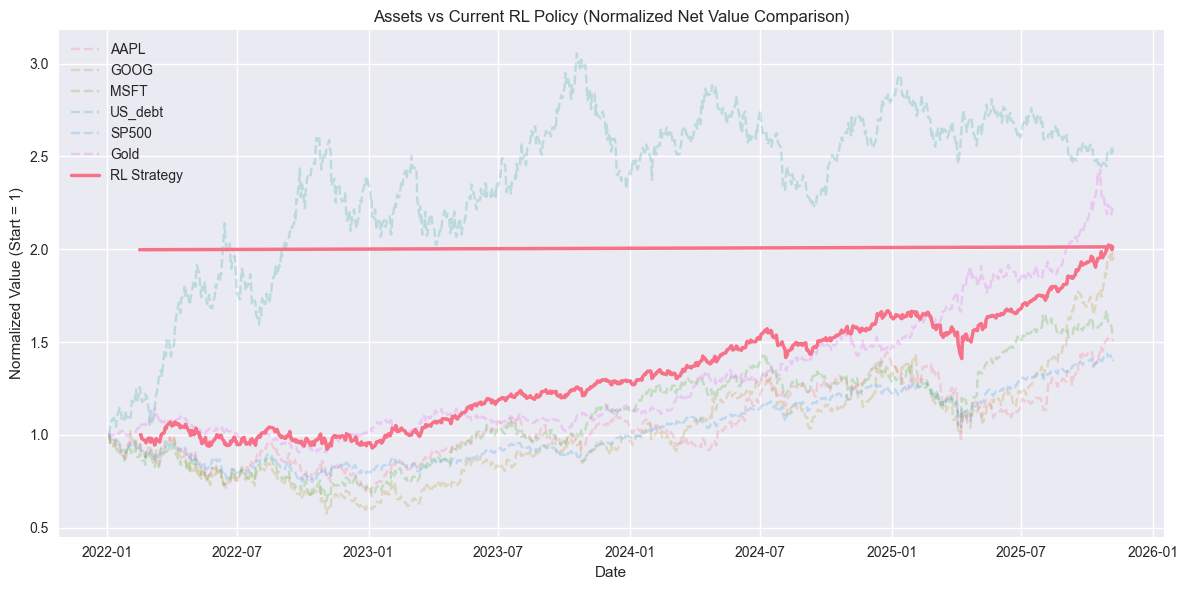

,AAPL,GOOG,MSFT,US_debt,SP500,Gold
date,,,,,,
2022-01-03,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2022-01-04,0.987308,0.995464,0.982853,1.018405,0.999370,1.007550
2022-01-05,0.961046,0.948847,0.945123,1.049080,0.979990,1.005163
2022-01-06,0.945003,0.948140,0.937655,1.061350,0.979045,0.994226
2022-01-07,0.945937,0.944373,0.938133,1.079755,0.975080,0.997335
...,...,...,...,...,...,...
2025-11-03,1.507763,1.971844,1.593290,2.533742,1.428518,2.228224
2025-11-04,1.513311,1.929787,1.584970,2.515337,1.411751,2.188031
2025-11-05,1.513872,1.976217,1.562875,2.558282,1.416909,2.215289


In [120]:
from matplotlib.lines import lineStyles
import matplotlib.pyplot as plt

asset_cols = tickers
prices = df.loc[plot_start:plot_end, asset_cols].copy()
norm_prices = prices / prices.iloc[0]

plt.figure(figsize=(12, 6))

for col in asset_cols:
    plt.plot(norm_prices.index, norm_prices[col], label=col, alpha=0.25,linestyle='--')

plt.plot(norm_equity.index, norm_equity, label="RL Strategy", linewidth=2.5)

plt.title("Assets vs Current RL Policy (Normalized Net Value Comparison)")
plt.xlabel("Date")
plt.ylabel("Normalized Value (Start = 1)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

norm_prices

# 修改部分

添加了科技股票、国债、标普500和黄金等数据作为环境输入特征

## 收益严重偏大，进行修改：

=== Portfolio Performance (deterministic rollout) ===
Periods per year (inferred): 252.00
Start wealth:  10297.47
End wealth:    23731074.08
Total growth:  2304.553868
CAGR:          804.485651%
Ann. Return (geom from equity): 804.485651%
Ann. Vol:      22.710210%
Sharpe (rf=0): 9.8502
Max Drawdown:  -5.59%
Calmar:        143.9561

### 1、对vec_env进行了归一化处理

=== Portfolio Performance (deterministic rollout) ===
Periods per year (inferred): 252.00
Start wealth:  10180.25
End wealth:    1013360.39
Total growth:  99.541782
CAGR:          270.067928%
Ann. Return (geom from equity): 270.067928%
Ann. Vol:      22.074986%
Sharpe (rf=0): 6.0514
Max Drawdown:  -8.50%
Calmar:        31.7818

### 2、调整奖励函数
用协方差矩阵估计组合波动
添加每次交易成本千一

=== Portfolio Performance (deterministic rollout) ===
Periods per year (inferred): 252.00
Start wealth:  10055.45
End wealth:    54941.09
Total growth:  5.463811
CAGR:          62.092061%
Ann. Return (geom from equity): 62.092061%
Ann. Vol:      17.712724%
Sharpe (rf=0): 2.8174
Max Drawdown:  -11.18%
Calmar:        5.5563

### 3、更换为sac算法

=== Portfolio Performance (deterministic rollout) ===
Periods per year (inferred): 252.00
Start wealth:  10145.52
End wealth:    22875.43
Total growth:  2.254731
CAGR:          26.016893%
Ann. Return (geom from equity): 26.016893%
Ann. Vol:      14.523819%
Sharpe (rf=0): 1.6653
Max Drawdown:  -12.48%
Calmar:        2.0840

删除了step函数中对动作的softmax处理

=== Portfolio Performance (deterministic rollout) ===
Periods per year (inferred): 252.00
Start wealth:  10096.53
End wealth:    36203.07
Total growth:  3.585696
CAGR:          43.791829%
Ann. Return (geom from equity): 43.791829%
Ann. Vol:      12.005115%
Sharpe (rf=0): 3.0874
Max Drawdown:  -8.52%
Calmar:        5.1418

# 优化奖励函数权重

benchmark:

lambda_risk = 1
lambda_turnover = 0.01
reward = base_reward - lambda_risk * risk_penalty - lambda_turnover * cost

=== Portfolio Performance (deterministic rollout) ===
Periods per year (inferred): 252.00
Start wealth:  10164.10
End wealth:    39643.65
Total growth:  3.900359
CAGR:          47.273482%
Ann. Return (geom from equity): 47.273482%
Ann. Vol:      17.140595%
Sharpe (rf=0): 2.3455
Max Drawdown:  -13.67%
Calmar:        3.4585